In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback, EarlyStopping

In [13]:
df = pd.read_parquet("cleaned.parquet")
df

,lyric_clean
0,he said the way my blue eyes shined
1,put those georgia stars to shame that night
2,i said that is a lie
3,just a boy in a chevy truck
4,that had a tendency of gettin' stuck
...,...
5310,even when i lose my mind
5311,i need to say
5312,tell me that it is not my fault
5313,tell me that i am all you want


## Using LSTM for Lyric Generation

In this project, I'm going to use LSTM (Long Short-Term Memory) networks for generating lyrics in the style of Taylor Swift.

### What is an LSTM?

LSTMs are a special kind of neural network that excel in learning from sequences, like sentences in a song. What LSTMs do with data—they remember not just the immediate past but also information from way back.

### How We Prepare Training Data and Labels

1. **Tokenization**: First, we convert the lyrics into a format that our LSTM model can understand. We do this by breaking down the lyrics into individual words and then converting each word into a unique number.

2. **Creating Input Sequences**: We then create sequences of these numbers. Each sequence is a part of a lyric line, and with each step, we add one word to the sequence. This way, the model learns to predict the next word in a sequence.

3. **Padding**: Since not all sequences are of the same length, we make them uniform by adding zeroes to the shorter sequences, a process known as padding.

4. **Splitting the Data**: The sequences are then divided into two parts: predictors and the label. The predictors are the sequences of numbers we input into the model, and the label is the next number that the model needs to predict.

5. **One-Hot Encoding**: Finally, we convert labels into a format where all possibilities are represented as zeroes, except the actual label, which is represented as a one.

6. **Train-Test Split**: Lastly, we split our dataset into a training set and a validation set. The training set is used to train the model, while the validation set is used to test its performance and accuracy.


In [14]:
combined_lyrics = ' '.join(df['lyric_clean'])
tokenizer = Tokenizer()
tokenizer.fit_on_texts([combined_lyrics])
total_words = len(tokenizer.word_index) + 1
input_sequences = []
for line in df['lyric_clean']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_len = max(len(x) for x in input_sequences)
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
label = to_categorical(label, num_classes=total_words)

# Splitting Data
X_train, X_val, y_train, y_val = train_test_split(predictors, label, test_size=0.2, random_state=42)

In [4]:
X_train

array([[   0,    0,    0, ...,    5,    6,   19],
       [   0,    0,    0, ...,   33,    2,   16],
       [   0,    0,    0, ...,    0,    0,    1],
       ...,
       [   0,    0,    0, ...,    0,   55,    3],
       [   0,    0,    0, ...,   19,    9, 1012],
       [   0,    0,    0, ...,    0,    0,   37]], dtype=int32)

In [15]:
# Perplexity Calculation
class Perplexity(Callback):
    def on_epoch_end(self, epoch, logs={}):
        cross_entropy = logs.get('loss')
        perplexity = np.exp(cross_entropy)
        print(f' - perplexity: {perplexity}')

def viz_metrics(history):
    # Visualizing Training and Validation Metrics
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

def train(model):
  earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto', restore_best_weights=True)
  history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[earlystop, Perplexity()])
  return history

def generate(model, seed_text):
  next_words = 100  # Number of words you want to generate

  for _ in range(next_words):
      # Tokenize the current seed text
      token_list = tokenizer.texts_to_sequences([seed_text])[0]

      # Pad the sequence
      token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

      # Predict the next word (as probabilities)
      probabilities = model.predict(token_list, verbose=0)

      # Get the index of the most likely next word
      predicted = np.argmax(probabilities, axis=-1)[0]

      # Convert the predicted token to a word
      output_word = ""
      for word, index in tokenizer.word_index.items():
          if index == predicted:
              output_word = word
              break

      # Update the seed text
      seed_text += " " + output_word

  return seed_text


def sample_with_temperature(probabilities, temperature=1.0):
    # Adjust the probabilities with temperature
    probabilities = np.asarray(probabilities).astype('float64')
    probabilities = np.log(probabilities + 1e-10) / temperature  # Adding a small constant to avoid division by zero
    exp_probs = np.exp(probabilities)
    probabilities = exp_probs / np.sum(exp_probs)

    # Sample the next word based on the adjusted probabilities
    choices = range(len(probabilities))
    next_word = np.random.choice(choices, p=probabilities)

    return next_word

def generate_with_temperature(model, seed_text, temperature=1.0):

    next_words = 100
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

        probabilities = model.predict(token_list, verbose=0)[0]

        # Use temperature to adjust the probabilities and sample the next word
        predicted = sample_with_temperature(probabilities, temperature=temperature)

        # Convert the predicted token to a word and update the seed text
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word

    return seed_text


## Baseline model


### Model Architecture

1. **Input Layer (Embedding Layer)**:
   - `Embedding`: The first layer is an Embedding layer, which is used to convert our input data into dense vectors of fixed size. Here, `total_words` is the size of the vocabulary, and `100` is the dimensionality of the embedding vectors. The `input_length` is set to `max_sequence_len - 1`, which is the length of the input sequences.

2. **LSTM Layer**:
   - `LSTM`: After the Embedding layer, we have an LSTM layer with 150 units. This layer will process the sequence of word embeddings output by the previous layer.
3. **Dropout for Regularization**:
   - `Dropout(0.1)`: Following the first LSTM layer, we set a Dropout layer with a dropout rate of 0.1 (10%). Dropout is a regularization technique where randomly selected neurons are ignored during training, which helps in preventing overfitting.

3. **Output Layer (Dense Layer)**:
   - `Dense`: The final layer is a Dense layer with a softmax activation function. The size of this layer is equal to `total_words`, which represents the total number of unique words in the vocabulary. The softmax activation function will output a probability distribution over the vocabulary for the next word in the sequence.

The loss function used is `categorical_crossentropy`, which is suitable for multi-class classification problems. We use the `adam` optimizer, which is an algorithm for first-order gradient-based optimization of stochastic objective functions. The metrics we are interested in monitoring is `accuracy`.

### Early Stopping

- `EarlyStopping`: EarlyStopping is a callback that stops the training process when a monitored metric has stopped improving. We are monitoring the validation loss (`val_loss`), and if the loss does not decrease (`min_delta=0`) for three epochs (`patience=3`), the training will stop. The `verbose=1` setting allows us to see the output of the early stopping events. The `mode='auto'` will determine the direction of improvement automatically and `restore_best_weights=True` ensures that the model's weights will revert to those that yielded the lowest validation loss.

If the `val_loss` begins to increase as training proceeds, it can be an indicator of overfitting.

### Training the Model

- The model will train for a maximum of 100 epochs on the training data `X_train` and `y_train`.

- During training, the model's performance is also validated using a separate validation set.

-  `Perplexity()` is  a custom callback (not provided in the standard Keras callbacks) which computes the perplexity metric after each epoch, a common evaluation metric in language modeling. A lower perplexity score indicates better predictive performance, as it means the model is more certain about its predictions.



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 22, 100)           357300    
                                                                 
 lstm_2 (LSTM)               (None, 150)               150600    
                                                                 
 dropout_2 (Dropout)         (None, 150)               0         
                                                                 
 dense_2 (Dense)             (None, 3573)              539523    
                                                                 
Total params: 1047423 (4.00 MB)
Trainable params: 1047423 (4.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
882/882 [==============================] - 16s 15ms/step - loss: 6.0899 - accuracy: 0.0498 - val_loss: 5.8455 - val_accuracy: 0.0723
Epo

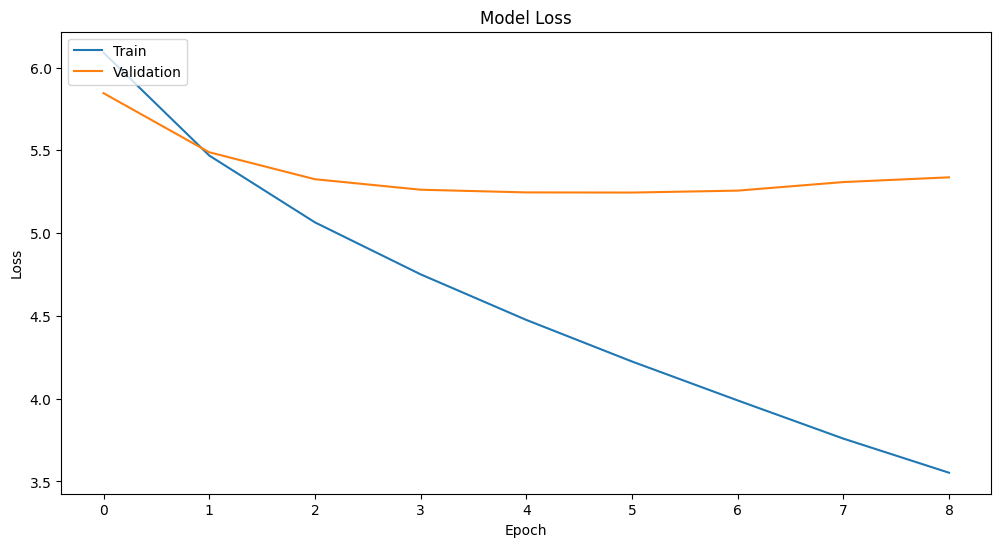

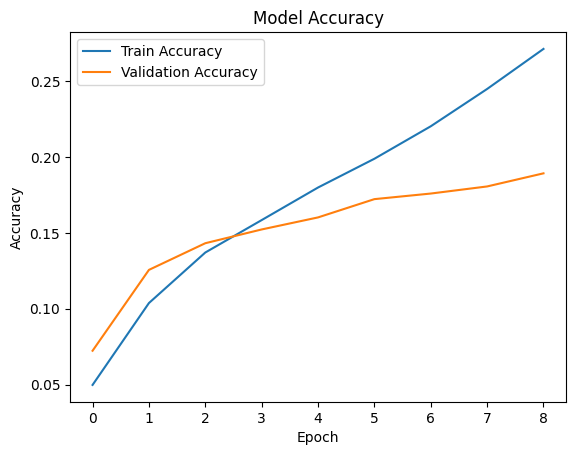

In [16]:
# Building the Model
baseline_model = Sequential()
baseline_model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
baseline_model.add(LSTM(150))
baseline_model.add(Dropout(0.1))
baseline_model.add(Dense(total_words, activation='softmax'))
baseline_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

baseline_model.summary()

history = train(baseline_model)
viz_metrics(history)

So we got:
- accuracy: 0.1989
- val_accuracy: 0.1723
- perplexity: 68.36582504661283

For generative models, such as those used in text generation, the objective is often to produce text that is coherent and contextually relevant, rather than to maximize the next-word prediction accuracy. A model could have lower accuracy but still generate high-quality, diverse text. This is because it may learn to produce text that follows the style and structure of the language, even though it doesn't always guess the exact word that appears in the training set.


### How Do We Generate Text?

1. **Starting with the Seed**: We begin with the seed text and prepare it for prediction. This involves tokenizing the text (converting words to numerical values) and padding it to ensure it fits the model's expected input shape.

2. **Word-by-Word Generation**:
   - The model predicts the next word based on the current seed text, one word at a time.
   - It outputs a probability distribution over the entire vocabulary for the next word.
   - The word corresponding to the highest probability (the most likely next word) is chosen and added to the seed text.

3. **Updating the Seed Text**:
   - After each prediction, the seed text is updated to include the new word.
   - This updated seed text is then fed back into the model for the next round of prediction.

4. **Repeating the Process**:
   - This loop continues for a set number of iterations (e.g., 100 words in our case).


In [17]:
generate(baseline_model, 'ring any bells')

'ring any bells i am not a girl i have been waiting waiting waiting waiting to me to me and you are the one time i am dreamer robber back to shoe shoe shoe shoe shoe be the way you have been waiting waiting waiting to me and you are shoe to be the way you are not me and you are shoe shoe shoe shoe to be the way you have been waiting waiting waiting to me and you are not me and you are not me and you are the one shoe shoe shoe shoe to be the way you are'

### Generating with Temperature (Sampling Softly):

- **Temperature**: When generating text, we can use a concept known as "temperature" to influence the randomness of predictions.
   - A high temperature results in more random predictions (more creative or surprising text).
   - A low temperature leads to more predictable predictions (often more repetitive text).
- The `sample_with_temperature` function adjusts the model's predicted probabilities before sampling the next word, allowing us to control the "creativity" of the generated text.


In [18]:
generate_with_temperature(baseline_model, 'ring any bells', 0.6)

"ring any bells i have been so much yeah you will do not you know mmm much you are with you in the first time leave you the name of everything i met your first car ever learned to take me in a crowded bushes down me in the parents' night oh oh oh memorizing crescent obsession tracks to me you will thn tarnished redneck hishands down my promises g5 heir betty i am not waiting up and again with the way you run lakes loses and the west yet are apart in a summer time i slamming lover the view weekend beds"

In [19]:
generate_with_temperature(baseline_model, 'ring any bells', 0.2)

'ring any bells i am not a girl girl i am not a girl girl i am not a girl girl i am not a girl girl i do not know what you know i am not a man man i do not know what you know i am not a man i have been waiting waiting waiting waiting to me and you are not you and i am a bad time i am not robber worst hero butt problem you are the way you are the best of me cynics shoe to me and shoe shoe shoe to be the way you'

**No Temperature (Default Behavior):**

The first generated text, without any temperature adjustment, shows a high level of repetition. This is a common characteristic of LSTM models when they become too confident about the next word, leading to a loop of repeated words or phrases.

**Temperature Setting: 0.6:**

With a temperature of 0.6, the generated text shows more variety and less repetition. The sentences appear more diverse and less predictable than in the no-temperature case. This indicates that a moderate temperature can encourage the model to explore a wider range of words while still maintaining a degree of coherence.

**Temperature Setting: 0.2:**

A lower temperature of 0.2 results in text that is somewhat repetitive but less so than the no-temperature case. It seems to strike a balance between repetition and randomness. The model is more conservative than at 0.6 but avoids getting stuck in as many repetitive loops.

I asked ChatGPT to format generation with 0.6 as a song and that what I got:


Ring any bells, I have been so much, yeah,

You will do, not you know, mmm much.

You are with you in the first time,

Leave you the name of everything I find.

I met your first car, ever learned to take,

Me in a crowded bushes, down by the lake.

Parents' night, oh oh oh, memorizing,

Crescent obsession, tracks to realizing.

You will, then tarnished, redneck his hands down,

My promises, G5 heir, Betty, wearing that crown.

I am not waiting up, and again with the way,

You run lakes, loses, and the west, day by day.

Yet are apart, in a summertime, I slamming,

Lover the view, weekend beds, no jamming.

I met your first car, ever learned to take,

Me in a crowded bushes, down by the lake.

Parents' night, oh oh oh, memorizing,

Crescent obsession, tracks to realizing.




## Exploring Different Architectures in LSTM Models



### Model 1 Architecture - Add another LSTM layer

1. **Embedding Layer**

2. **First LSTM Layer with Return Sequences**: this LSTM layer has 150 units, but unlike the previous model,
it is configured with `return_sequences=True`. This setting allows the layer to return the full sequence of outputs to the next layer instead of just the output of the last time step.

3. **Dropout for Regularization (First Instance)**:
   - `Dropout(0.1)`: Following the first LSTM layer, we set a Dropout layer with a dropout rate of 0.1 (10%). Dropout is a regularization technique where randomly selected neurons are ignored during training, which helps in preventing overfitting.

4. **Second LSTM Layer**:
   - `LSTM(100)`: A second LSTM layer follows, this time with 100 units. This layer does not return the full sequences, but only the output of the last time step, which is suitable for feeding into the Dense output layer.

5. **Dropout for Regularization (Second Instance)**:
   - Another Dropout layer is added with the same rate of 0.1, further helping in the regularization process.

6. **Dense Output Layer**:
   - `Dense(total_words, activation='softmax')`: The final layer remains a Dense layer with a softmax activation function.


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 22, 100)           357300    
                                                                 
 lstm_3 (LSTM)               (None, 22, 150)           150600    
                                                                 
 dropout_3 (Dropout)         (None, 22, 150)           0         
                                                                 
 lstm_4 (LSTM)               (None, 100)               100400    
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 3573)              360873    
                                                                 
Total params: 969173 (3.70 MB)
Trainable params: 96917

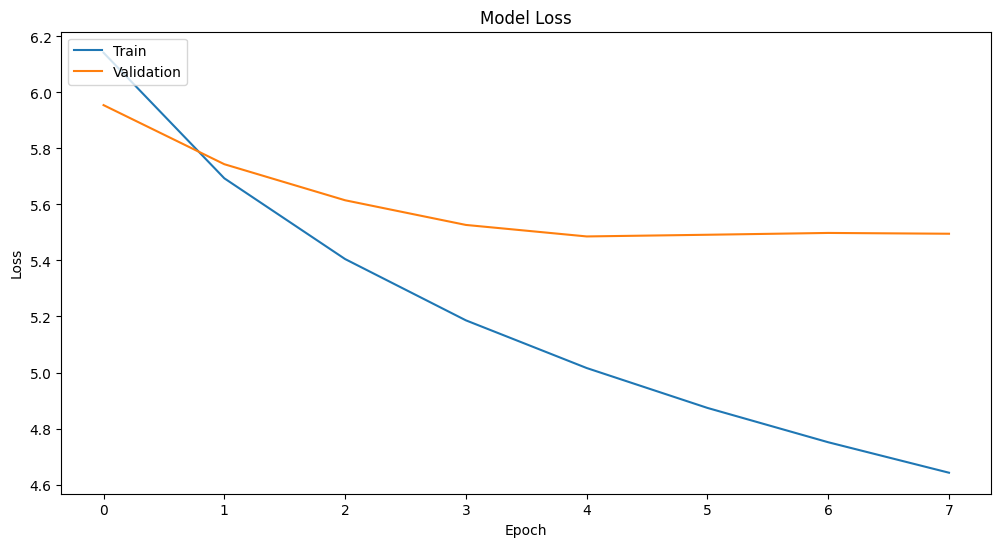

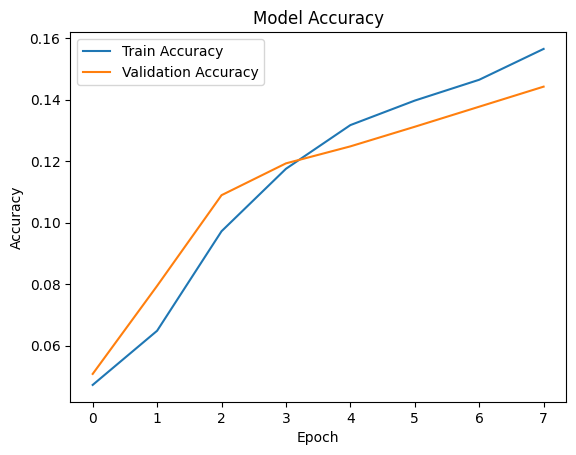

In [20]:
# Building the Model
model1 = Sequential()
model1.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model1.add(LSTM(150, return_sequences=True))
model1.add(Dropout(0.1))
model1.add(LSTM(100))
model1.add(Dropout(0.1))
model1.add(Dense(total_words, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()

history = train(model1)
viz_metrics(history)

- accuracy: 0.1317
- val_accuracy: 0.1248
- perplexity: 150.8049675343064

Accuracy and preplexity are lower than in the baseline model, let's look at generated text

In [21]:
print(generate(model1, 'ring any bells'))
print(generate_with_temperature(model1, 'ring any bells', 0.6))
print(generate_with_temperature(model1, 'ring any bells', 0.2))

ring any bells to be the time i am the time i am the time i am the time i am the doctor treat treat treat treat treat treat treat treat treat treat treat treat treat treat treat treat treat the doctor treat treat the time i am the time i am the time i am the time i am the doctor treat the time treat treat treat treat treat treat treat treat treat treat treat treat treat treat the doctor treat treat the time treat the time i am the time i am the time i am the time treat treat the
ring any bells but you are the day we will be books out in you you are a other my car ever like the lotta in hunting traits toy a simply flashing remembering to hero's boat believing wideeyed olive balancin' diamonds insult contempt seeing podium fever basement storms roots climbed vanished crowns soundtrack drawing at me in me weird marked it is nice by the things lave reflection in my night too and your worst thing you are late in the time for pacin' iisland aglow hunter oh hmm and coast cowboy do vision bass

### Model 2 Architecture - Add Biderectional wrapper with 1 layers and with 2 layers

The Bidirectional wrapper allows the LSTM to process the input sequence in both forward and backward directions, capturing patterns that may be missed when the sequence is processed in only one direction. The `return_sequences=True` parameter ensures that the output for each timestep is returned, making it suitable for connecting to subsequent recurrent layers.


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 22, 100)           357300    
                                                                 
 bidirectional (Bidirection  (None, 300)               301200    
 al)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 300)               0         
                                                                 
 dense_4 (Dense)             (None, 3573)              1075473   
                                                                 
Total params: 1733973 (6.61 MB)
Trainable params: 1733973 (6.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
882/882 [==============================] - 21s 18ms/step - loss: 6.028

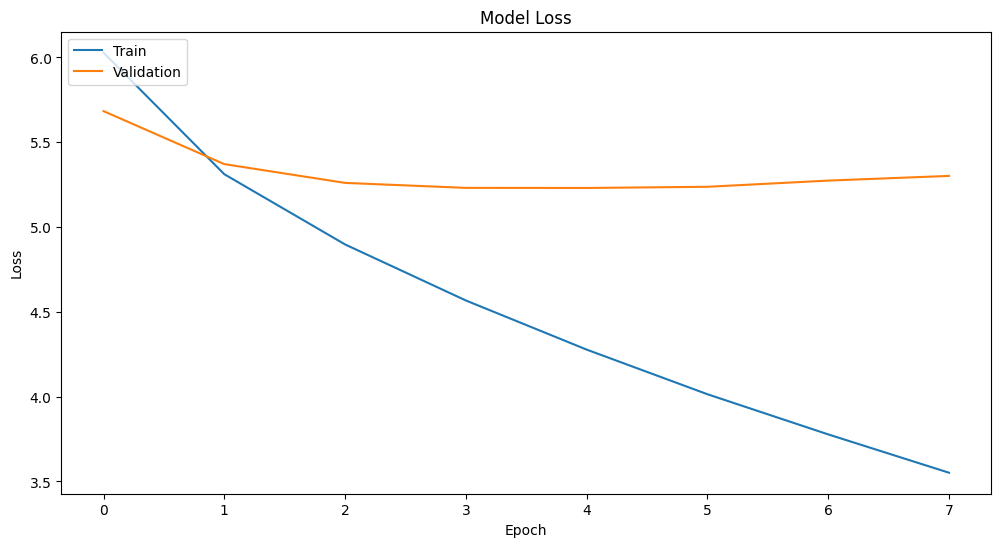

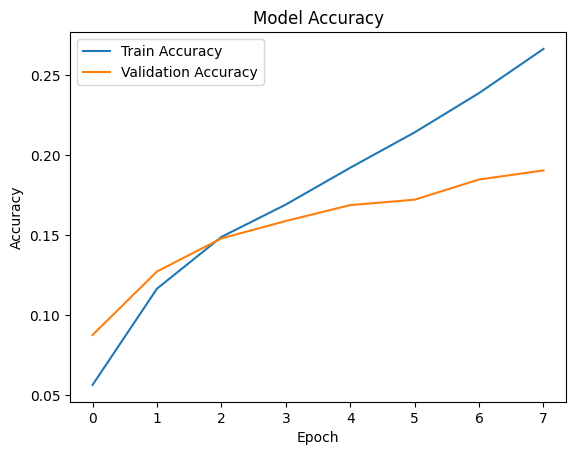

In [22]:
model2_1 = Sequential()
model2_1.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model2_1.add(Bidirectional(LSTM(150)))
model2_1.add(Dropout(0.1))
model2_1.add(Dense(total_words, activation='softmax'))
model2_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2_1.summary()

history = train(model2_1)
viz_metrics(history)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 22, 100)           357300    
                                                                 
 bidirectional_1 (Bidirecti  (None, 22, 500)           702000    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 22, 500)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 300)               781200    
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 300)               0         
                                                                 
 dense_5 (Dense)             (None, 3573)             

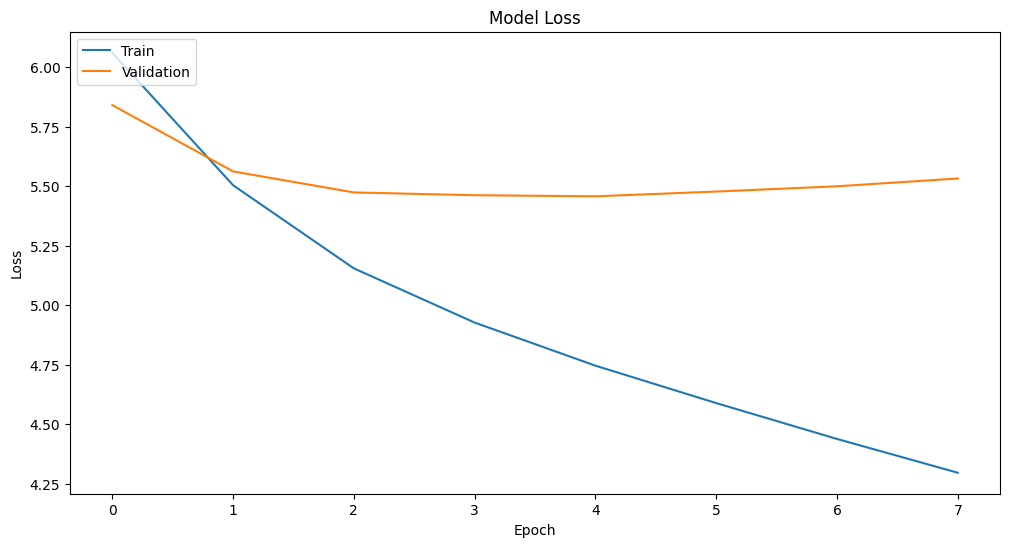

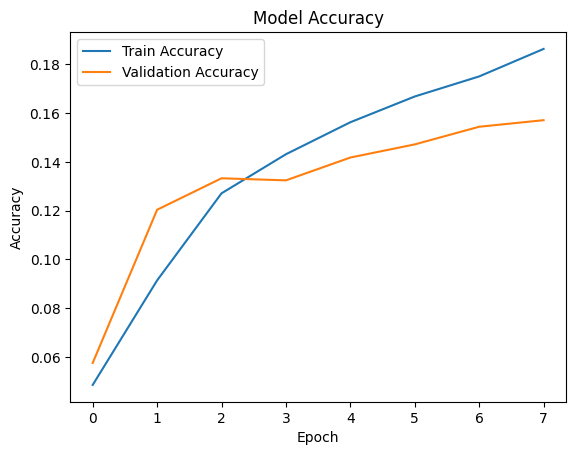

In [23]:
model2_2 = Sequential()
model2_2.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model2_2.add(Bidirectional(LSTM(250, return_sequences=True)))
model2_2.add(Dropout(0.1))
model2_2.add(Bidirectional(LSTM(150)))
model2_2.add(Dropout(0.1))
model2_2.add(Dense(total_words, activation='softmax'))
model2_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2_2.summary()

history = train(model2_2)
viz_metrics(history)

model2_1:
- accuracy: 0.1921
- val_accuracy: 0.1687
- perplexity: 72.06663870106583

model2_2:
- accuracy: 0.1563
- val_accuracy: 0.1418
- perplexity: 115.10034462339802

Accuracy and preplexity are lower than in the baseline model but model2_1 performs better than model1 and model2_2, let's look at the generated text.

In [24]:
generate(model2_1, 'ring any bells')

'ring any bells to be the same of the girl of you are a girl of you i am not waiting waiting to you and i am not waiting to you to be the way you to be the way you are the one of you oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh'

In [25]:
generate_with_temperature(model2_1, 'ring any bells', 0.6)

'ring any bells i would be the man for me to you and that i am not to the man i want you i do not even follow you i would follow it all at your hands back to me like the things you are not me to you and it is a way or a little time oh oh oh oh oh oh oh oh oh oh oh oh oh i am that i did you know that you are so seats of the rest of the day of the phone i want you are the one thing i am stealing thing'

In [26]:
generate_with_temperature(model2_1, 'ring any bells', 0.2)

'ring any bells to be the same of the first time i am not waiting waiting to you to be the way you to me to me you are me to me to me to me you are the one of me i am not there is not you to be the one of you oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh'

### Model 3 Architecture - GRU layer

The GRU (Gated Recurrent Unit) is a type of recurrent neural network (RNN) layer similar to LSTM (Long Short-Term Memory). It's designed to solve the vanishing gradient problem which can occur in traditional RNNs during backpropagation, especially with long sequences of data.

Looks like 1 layer works just fine on my data, so I will try also 1 layer of GRU

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 22, 100)           357300    
                                                                 
 gru (GRU)                   (None, 150)               113400    
                                                                 
 dropout_8 (Dropout)         (None, 150)               0         
                                                                 
 dense_6 (Dense)             (None, 3573)              539523    
                                                                 
Total params: 1010223 (3.85 MB)
Trainable params: 1010223 (3.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
882/882 [==============================] - 17s 16ms/step - loss: 5.9716 - accuracy: 0.0711 - val_loss: 5.5051 - val_accuracy: 0.1188
Epo

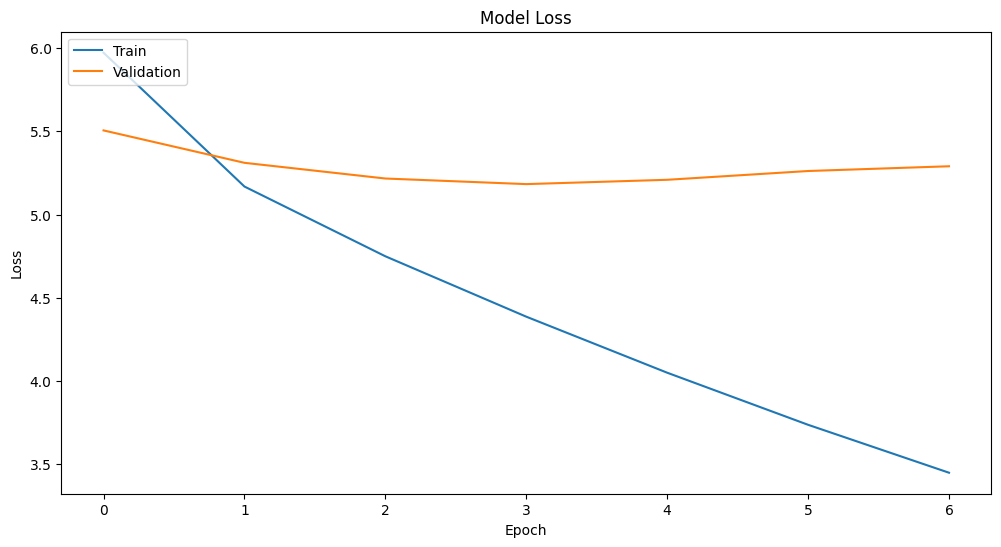

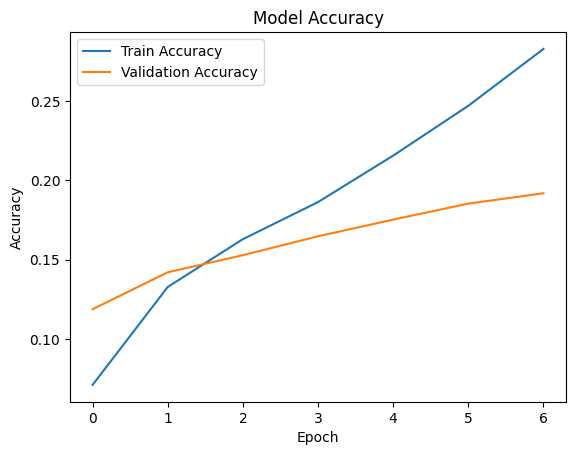

In [27]:
# Building the Model
model3 = Sequential()
model3.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model3.add(GRU(150))
model3.add(Dropout(0.1))
model3.add(Dense(total_words, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model3.summary()

history = train(model3)
viz_metrics(history)

- accuracy: 0.1863
- val_accuracy: 0.1648
- perplexity: 80.37602128493704

Overall, looks like 1 layer is enough, also simple LSTM works a bit better than Biderectional(LSTM) or GRU

In [28]:
generate(model3, 'ring any bells')

'ring any bells and i am not you ever fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake fake'

In [29]:
generate_with_temperature(model3, 'ring any bells', 0.6)

'ring any bells love is it in the bathroom of the night i know that i cannot help you i cannot have to be a man cuts me around you putting me like gone all of a getaway room since i was a man of you i just cannot hear to look out the phone to you mean me i will be a man you are there when you are still on me out of the woods yet are a man of it all of a little thorns and reads thorns as fate will always see it all so good she is so'

In [30]:
generate_with_temperature(model3, 'ring any bells', 0.2)

'ring any bells and i am not the man one of me i am still trying to be your first string oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh'

### Model 4 Architecture - Using Pretrained Word Embeddings

To use this model you should download from [this link](https://nlp.stanford.edu/projects/glove/) glove.6B.zip
archive, unzip it, find glove.6B.100d.txt and upload it to Google Colab near cleaned.parquet file. It's too big to be uploaded onto github.


In this iteration of our model, `model4`, we are improving our text generation capabilities by incorporating pre-trained word embeddings from GloVe (Global Vectors for Word Representation). This approach brings the power of word embeddings trained on a vast corpus of text, capturing intricate word relationships and semantics.

### What are GloVe Embeddings?

- **GloVe Embeddings**: GloVe is an unsupervised learning algorithm developed by Stanford for generating word embeddings by aggregating global word-word co-occurrence statistics from a corpus. The idea is to derive semantic relationships between words from the co-occurrence patterns of words in a large text corpus.

### Using Pre-Trained GloVe Embeddings

1. **Loading GloVe Embeddings**:
   - The GloVe embeddings are loaded from a pre-trained file, `glove.6B.100d.txt`. Each line in this file contains a word followed by its embedding vector (of 100 dimensions in our case).
   - These embeddings are stored in a dictionary, where the key is the word and the value is its corresponding vector.

2. **Creating an Embedding Matrix**:
   - An embedding matrix is created where each row corresponds to a token in our vocabulary. The matrix is initially filled with zeros and has dimensions `total_words x 100` (total number of unique words in our dataset x embedding dimensions).
   - For each word in our tokenizer's word index, we retrieve the corresponding GloVe vector and place it in the respective row in the matrix. This creates a custom embedding matrix tailored to our vocabulary.


### Model Architecture with GloVe Embeddings

- **Embedding Layer with GloVe Weights**:
  - The Embedding layer is now initialized with the weights from our GloVe embedding matrix. `trainable=False` is set to keep these embeddings fixed during training.

- **LSTM Layer**:
  - A standard LSTM layer follows the embedding layer to capture temporal dependencies.

- **Dropout for Regularization**:
  - A Dropout layer is added for regularization.

- **Dense Output Layer**:
  - The final Dense layer with a softmax activation function for predicting the next word.

In [33]:
import numpy as np

# Load GloVe embeddings
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create an embedding matrix
embedding_matrix = np.zeros((total_words, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None and i < total_words:
        embedding_matrix[i] = embedding_vector


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 22, 100)           357300    
                                                                 
 lstm_9 (LSTM)               (None, 150)               150600    
                                                                 
 dropout_10 (Dropout)        (None, 150)               0         
                                                                 
 dense_8 (Dense)             (None, 3573)              539523    
                                                                 
Total params: 1047423 (4.00 MB)
Trainable params: 690123 (2.63 MB)
Non-trainable params: 357300 (1.36 MB)
_________________________________________________________________
Epoch 1/100
882/882 [==============================] - 9s 8ms/step - loss: 6.0195 - accuracy: 0.0681 - val_loss: 5.7041 - val_accuracy: 0.0998
Epo

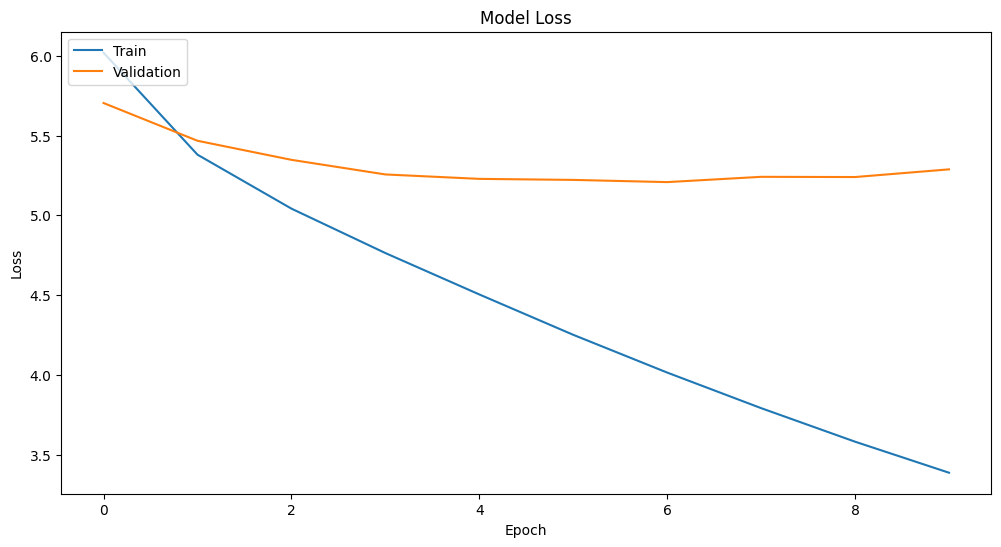

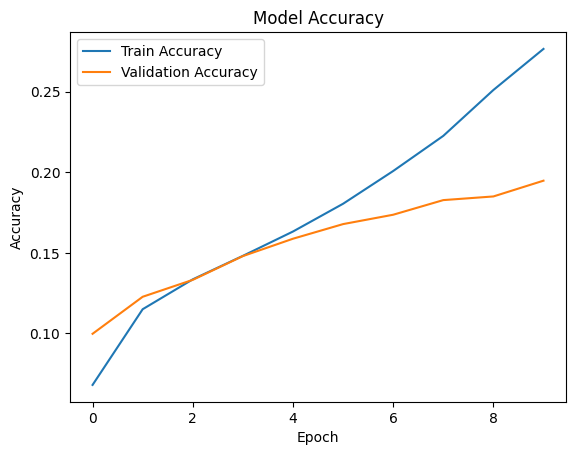

In [34]:
model4 = Sequential()
model4.add(Embedding(total_words, 100, weights=[embedding_matrix], input_length=max_sequence_len-1, trainable=False))
model4.add(LSTM(150))
model4.add(Dropout(0.1))
model4.add(Dense(total_words, activation='softmax'))
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model4.summary()

history = train(model4)
viz_metrics(history)


- accuracy: 0.2008
- val_accuracy: 0.1737
- perplexity: 55.370246210840754

In [35]:
generate(model4, 'ring any bells')

'ring any bells in the middle of the night we i am the one i want you go back to me you i am the one i want you go back to me you i am the one i want you go back to me you i am the one i want you go back to me you i am the one i want you go back to me you i am the one i want you go back to me you i am the one i want you go back to me you i am the one i want you go back'

In [38]:
generate_with_temperature(model4, 'ring any bells', 0.6)

"ring any bells i had thinkin' for sure i want to be the one thing that i am a mastermind to make it is not simple girl to figure me yeah oh oh yeah oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh i am gonna be wanna be you were here you are the best thing ooh i do not wanna be the one one friend i am with you you"

In [37]:
generate_with_temperature(model4, 'ring any bells', 0.2)

'ring any bells in the middle of the night we i am the one i want you to be the man man i am the one i want you go with me you are the best of me that you are the lucky one oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh'

## Fine-Tuning the Model

So model4 with pretrained embeddings has the highest accuracy and the lowest perplexity. Let's see if we can improve it

### 1. Optimizer

**RMSprop:**

Similar to Adam, it adapts the learning rate for each parameter.
Particularly effective in recurrent neural networks and in situations where Adam doesn't perform well.
Maintains a moving average of the square of gradients.

**Adagrad:**

Adapts the learning rate to the parameters, performing larger updates for infrequent parameters and smaller updates for frequent parameters.
Well-suited for dealing with sparse data (e.g., text data, recommendation systems).

**Adadelta:**

An extension of Adagrad that seeks to reduce its aggressive, monotonically decreasing learning rate.
Does not require a default learning rate setting. I'm not using it in the code below because it drastically increase learning time and doesn't bring any improvement

In [39]:
for optimizer in ['rmsprop', 'adagrad']:
    model = Sequential()
    model.add(Embedding(total_words, 100, weights=[embedding_matrix], input_length=max_sequence_len-1, trainable=False))
    model.add(LSTM(150))
    model.add(Dropout(0.1))
    model.add(Dense(total_words, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    history = train(model)


Epoch 1/100
882/882 [==============================] - 10s 8ms/step - loss: 6.0704 - accuracy: 0.0626 - val_loss: 5.8306 - val_accuracy: 0.0923
Epoch 2/100
882/882 [==============================] - 7s 8ms/step - loss: 5.7030 - accuracy: 0.1024 - val_loss: 5.6463 - val_accuracy: 0.1157
Epoch 3/100
882/882 [==============================] - 6s 7ms/step - loss: 5.5397 - accuracy: 0.1187 - val_loss: 5.5167 - val_accuracy: 0.1253
Epoch 4/100
882/882 [==============================] - 7s 8ms/step - loss: 5.4440 - accuracy: 0.1305 - val_loss: 5.4442 - val_accuracy: 0.1330
Epoch 5/100
882/882 [==============================] - 6s 7ms/step - loss: 5.3706 - accuracy: 0.1369 - val_loss: 5.4028 - val_accuracy: 0.1367
Epoch 6/100
882/882 [==============================] - 7s 8ms/step - loss: 5.3203 - accuracy: 0.1436 - val_loss: 5.3547 - val_accuracy: 0.1404
Epoch 7/100
882/882 [==============================] - 6s 7ms/step - loss: 5.2685 - accuracy: 0.1487 - val_loss: 5.3332 - val_accuracy: 0.141

Adam:
- accuracy: 0.2008
- val_accuracy: 0.1737
- perplexity: 55.370246210840754

RMSprop:
- accuracy: 0.1888
- val_accuracy: 0.1655
- perplexity: 141.92732248124054

Adagrad:
To slow, not even close after 100 epochs

### 2. Dropout rate and number of nodes in LSTM layer

In [40]:
for nodes in [100, 150, 300, 450]:
  for dropout_rate in [0.1, 0.2, 0.3, 0.4, 0.5]:
    print('nodes:', nodes, 'dropout_rate:', dropout_rate)
    model = Sequential()
    model.add(Embedding(total_words, 100, weights=[embedding_matrix], input_length=max_sequence_len-1, trainable=False))
    model.add(LSTM(nodes))
    model.add(Dropout(dropout_rate))
    model.add(Dense(total_words, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = train(model)

nodes: 100 dropout_rate: 0.1
Epoch 1/100
882/882 [==============================] - 9s 8ms/step - loss: 6.0969 - accuracy: 0.0554 - val_loss: 5.8607 - val_accuracy: 0.0798
Epoch 2/100
882/882 [==============================] - 7s 8ms/step - loss: 5.5777 - accuracy: 0.0930 - val_loss: 5.6475 - val_accuracy: 0.1140
Epoch 3/100
882/882 [==============================] - 6s 7ms/step - loss: 5.2771 - accuracy: 0.1189 - val_loss: 5.4921 - val_accuracy: 0.1253
Epoch 4/100
882/882 [==============================] - 7s 7ms/step - loss: 5.0243 - accuracy: 0.1351 - val_loss: 5.3972 - val_accuracy: 0.1334
Epoch 5/100
882/882 [==============================] - 6s 7ms/step - loss: 4.8089 - accuracy: 0.1449 - val_loss: 5.3495 - val_accuracy: 0.1449
Epoch 6/100
882/882 [==============================] - 7s 8ms/step - loss: 4.6222 - accuracy: 0.1539 - val_loss: 5.2975 - val_accuracy: 0.1496
Epoch 7/100
882/882 [==============================] - 6s 7ms/step - loss: 4.4550 - accuracy: 0.1640 - val_loss: 

nodes: 100 dropout_rate: 0.1

- accuracy: 0.1640
- val_accuracy: 0.1578
- perplexity: 86.06041200119246


nodes: 100 dropout_rate: 0.2
- accuracy: 0.1815
- val_accuracy: 0.1674
- perplexity: 68.12579448425312

nodes: 100 dropout_rate: 0.3
- accuracy: 0.1517
- val_accuracy: 0.1500
- perplexity: 105.80307771312769

nodes: 100 dropout_rate: 0.4
- accuracy: 0.1654
- val_accuracy: 0.1643
- perplexity: 83.87219141318924

nodes: 100 dropout_rate: 0.5
- accuracy: 0.1517
- val_accuracy: 0.1500
- perplexity: 105.80307771312769

As you can see, 100 nodes is not a good choice

nodes: 150 dropout_rate: 0.1
- accuracy: 0.1945
- val_accuracy: 0.1691
- perplexity: 58.14609468303044

nodes: 150 dropout_rate: 0.2
- accuracy: 0.2057
- val_accuracy: 0.1781
- perplexity: 52.34548645772148

nodes: 150 dropout_rate: 0.3
- accuracy: 0.1778
- val_accuracy: 0.1694
- perplexity: 74.60974421353097

nodes: 150 dropout_rate: 0.4
- accuracy: 0.1676
- val_accuracy: 0.1619
- perplexity: 89.90405599952292

nodes: 150 dropout_rate: 0.5
- accuracy: 0.1607
- val_accuracy: 0.1640
- perplexity: 96.35891794866741

150 nodes and 0.2 dropout rate won this round.

nodes: 300 dropout_rate: 0.1
- accuracy: 0.2162
- val_accuracy: 0.1836
- perplexity: 50.15569391980899

nodes: 300 dropout_rate: 0.2
- accuracy: 0.2037
- val_accuracy: 0.1769
- perplexity: 56.92185614038149

nodes: 300 dropout_rate: 0.3
- accuracy: 0.1822
- val_accuracy: 0.1714
- perplexity: 72.60291645793902

nodes: 300 dropout_rate: 0.4
- accuracy: 0.1939
- val_accuracy: 0.1786
- perplexity: 64.9289187419264

nodes: 300 dropout_rate: 0.5
- accuracy: 0.1914
- val_accuracy: 0.1838
- perplexity: 68.5090861551915

Config nodes: 300 dropout_rate: 0.1 performs better than previous configs

nodes: 450 dropout_rate: 0.1
- accuracy: 0.2026
- val_accuracy: 0.1798
- perplexity: 58.19960316389475

nodes: 450 dropout_rate: 0.2
- accuracy: 0.2433
- val_accuracy: 0.1931
- perplexity: 40.40445449560043

nodes: 450 dropout_rate: 0.3
- accuracy: 0.2149
- val_accuracy: 0.1846
- perplexity: 51.75818354460304

nodes: 450 dropout_rate: 0.4
- accuracy: 0.1982
- val_accuracy: 0.1816
- perplexity: 66.13159204873173

nodes: 450 dropout_rate: 0.5
- accuracy: 0.1977
- val_accuracy: 0.1847
- perplexity: 64.29333448611023

In the end of the test, nodes: 450 dropout_rate: 0.2 won

Let's train and save the final model

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 22, 100)           357300    
                                                                 
 lstm_33 (LSTM)              (None, 450)               991800    
                                                                 
 dropout_34 (Dropout)        (None, 450)               0         
                                                                 
 dense_32 (Dense)            (None, 3573)              1611423   
                                                                 
Total params: 2960523 (11.29 MB)
Trainable params: 2603223 (9.93 MB)
Non-trainable params: 357300 (1.36 MB)
_________________________________________________________________
Epoch 1/100
882/882 [==============================] - 10s 9ms/step - loss: 5.8611 - accuracy: 0.0850 - val_loss: 5.4886 - val_accuracy: 0.1181

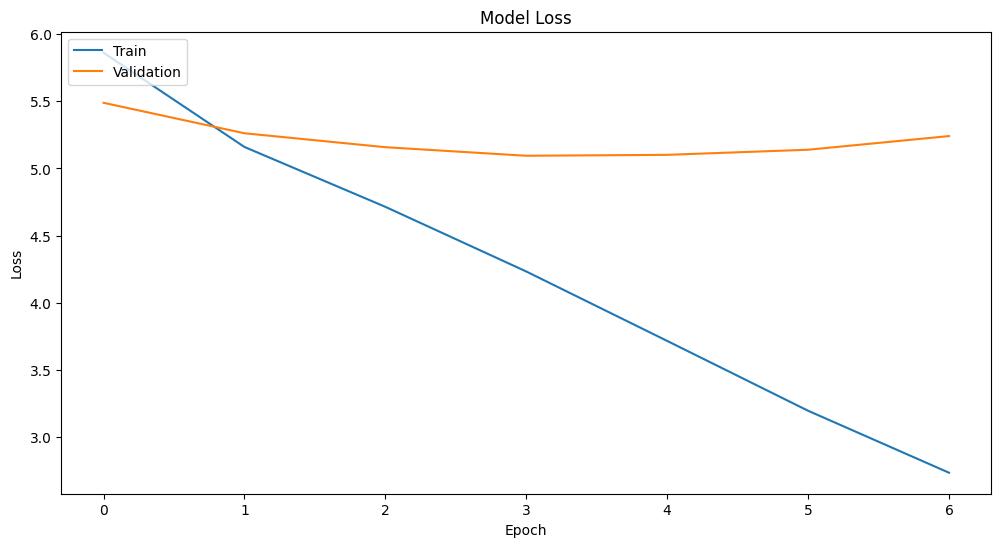

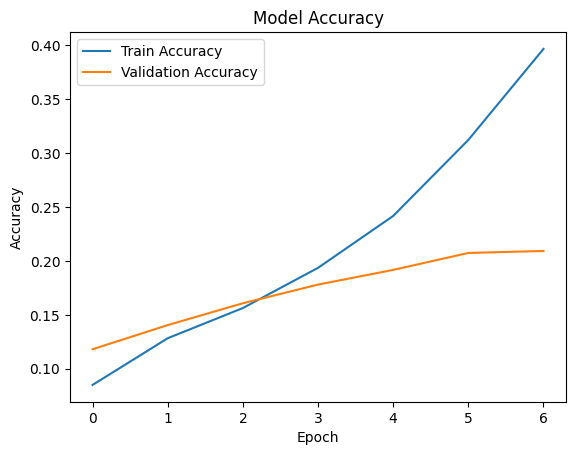

In [48]:
final_model = Sequential()
final_model.add(Embedding(total_words, 100, weights=[embedding_matrix], input_length=max_sequence_len-1, trainable=False))
final_model.add(LSTM(450))
final_model.add(Dropout(0.2))
final_model.add(Dense(total_words, activation='softmax'))
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

final_model.summary()

history = train(final_model)
viz_metrics(history)


In [50]:
generate_with_temperature(final_model, 'ring any bells', 0.6)

'ring any bells guys so i know i will not hear you go to come you you you go a step to you you it is me what you are never you are my baby oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh'

Actually, despite that fact that this model has the best metrics among my models, it generates not so good texts as my baseline model, they are too repetative even with temperature. So I'm going to change the final model to baseline model and save it.

In [51]:
# Save the model
baseline_model.save('my_lyric_model.h5')

import pickle

# Assume 'tokenizer' is your Keras Tokenizer instance
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# After defining max_sequence_len during training
with open('max_sequence_len.txt', 'w') as f:
    f.write(str(max_sequence_len))


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
